<a href="https://colab.research.google.com/github/Charana04/Stock-price-prediction/blob/main/Stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stock price prediction


In [ ]:
# Import necessary libraries
import pandas as pd

# Load the dataset
file_path = '/content/adani.csv'  # Adjust the path if needed
data = pd.read_csv(file_path)

# Convert timestamp to readable date format and set it as the index
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ns')
data.set_index('timestamp', inplace=True)

# Remove rows with negative values in price-related columns
data_cleaned = data[(data[['open', 'high', 'low', 'close']] >= 0).all(axis=1)]

# Display dataset stats
print(f"Cleaned dataset shape: {data_cleaned.shape}")
print(data_cleaned.head())


Cleaned dataset shape: (38328, 9)
                         symbol  \
timestamp                         
2024-11-28 18:30:00         AWL   
2024-11-28 18:30:00         ACC   
2024-11-28 18:30:00        ATGL   
2024-11-28 18:30:00  ADANIPORTS   
2024-11-28 18:30:00        NDTV   

                                                           company  \
timestamp                                                            
2024-11-28 18:30:00                           Adani Wilmar Limited   
2024-11-28 18:30:00                                    ACC Limited   
2024-11-28 18:30:00                        Adani Total Gas Limited   
2024-11-28 18:30:00  Adani Ports and Special Economic Zone Limited   
2024-11-28 18:30:00                   New Delhi Television Limited   

                            open         high          low        close  \
timestamp                                                                 
2024-11-28 18:30:00   314.000000   320.649994   310.200012   313.649994   
2024

In [ ]:
# Calculate 7-day moving average
data_cleaned['close_7d_avg'] = data_cleaned.groupby('symbol')['close'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

# Check for NaN values after calculating moving average
data_cleaned = data_cleaned.dropna(subset=['close_7d_avg'])

# Scale features with consistent indices
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = data_cleaned[['open', 'high', 'low', 'volume', 'close']]

# Scale data and reassign it with consistent index
scaled_features = pd.DataFrame(
    scaler.fit_transform(scaled_features),
    columns=['open', 'high', 'low', 'volume', 'close'],
    index=scaled_features.index  # Ensure the indices match
)

print("Sample of scaled features:")
print(scaled_features.head())


Sample of scaled features:
                         open      high       low    volume     close
timestamp                                                            
2024-11-28 18:30:00  0.075309  0.076629  0.076385  0.013651  0.075400
2024-11-28 18:30:00  0.522922  0.534971  0.536887  0.003482  0.534333
2024-11-28 18:30:00  0.194135  0.206011  0.194186  0.086272  0.195296
2024-11-28 18:30:00  0.281828  0.290522  0.287852  0.038864  0.286102
2024-11-28 18:30:00  0.042593  0.043981  0.043582  0.003167  0.042922


<ipython-input-8-aebe3e713f09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['close_7d_avg'] = data_cleaned.groupby('symbol')['close'].transform(


In [ ]:
# Filter for a specific stock symbol (e.g., 'AWL')
stock_data = data_cleaned[data_cleaned['symbol'] == 'AWL'].dropna()

# Define features and target
features = ['open', 'high', 'low', 'volume', 'close_7d_avg']
target = 'close'

X = stock_data[features].dropna()
y = stock_data[target].loc[X.index]

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data size: {X_train.shape[0]}, Testing data size: {X_test.shape[0]}")


Training data size: 554, Testing data size: 139


Linear Regression - MAE: 3.41, RMSE: 5.10
Random Forest - MAE: 4.48, RMSE: 7.44


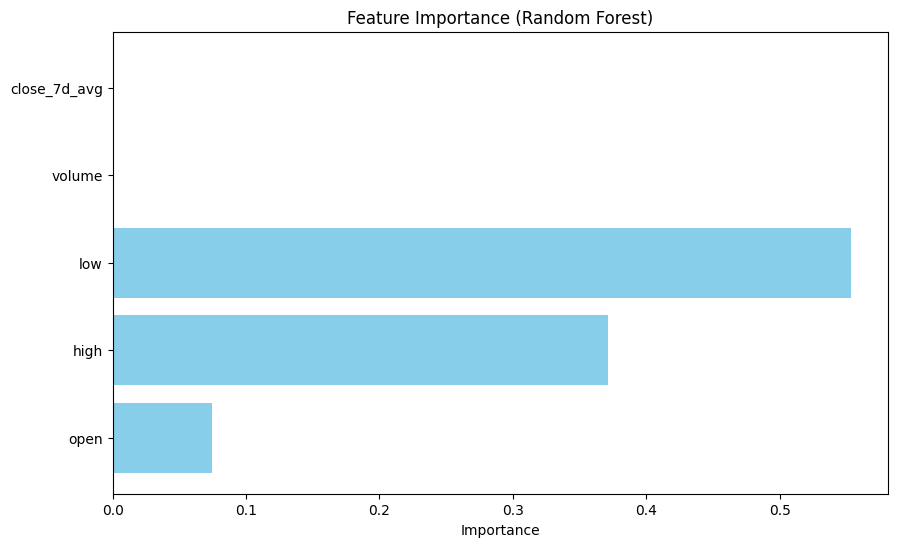

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate models
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Linear Regression - MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}")
print(f"Random Forest - MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")

# Feature Importance (Random Forest)
import matplotlib.pyplot as plt

importance = rf_model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()


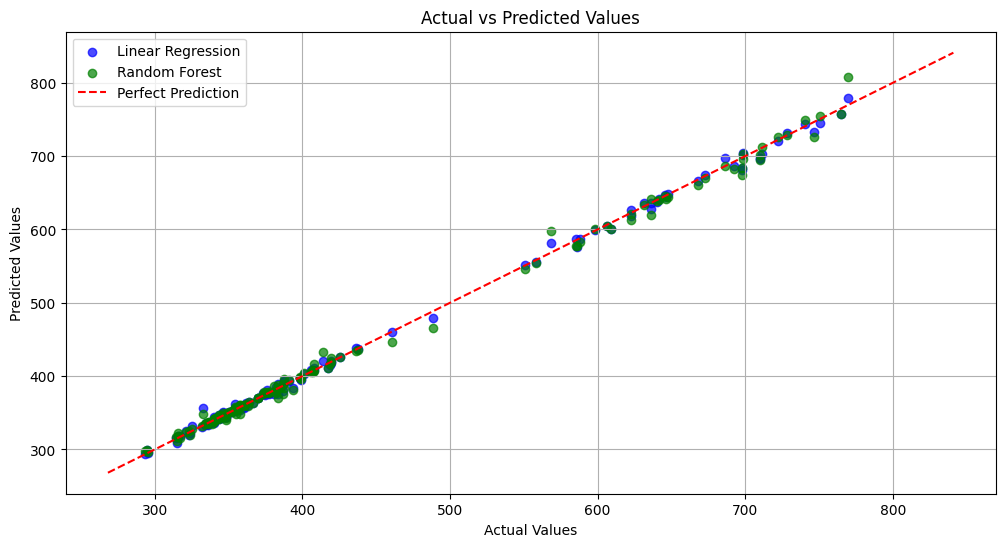

In [ ]:
# Actual vs Predicted Scatter Plot
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.7, label='Linear Regression', color='blue')
plt.scatter(y_test, y_pred_rf, alpha=0.7, label='Random Forest', color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid()
plt.show()


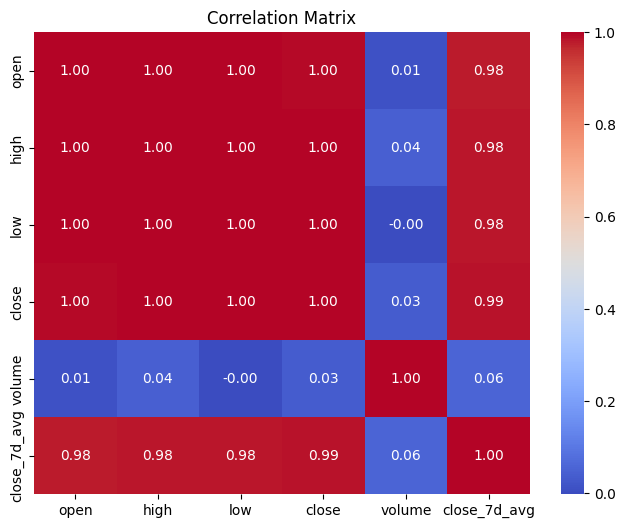

In [ ]:
import seaborn as sns

# Correlation Matrix
plt.figure(figsize=(8, 6))
corr_matrix = stock_data[['open', 'high', 'low', 'close', 'volume', 'close_7d_avg']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
